In [69]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [70]:
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

In [71]:
#data = datasets.load_iris()
data = datasets.load_wine()
X = data.data
Y = data.target
qubits_number = len(X[0])
device = qml.device("default.qubit", wires=qubits_number)

In [72]:
def prepare_layer(weights, r):
    for i in range(qubits_number):
        qml.Rot(weights[i, 0], weights[i, 1], weights[i, 2], wires=i)
    
    for i in range(qubits_number):
        qml.CNOT(wires=[i, (i+r)%qubits_number])

In [73]:
def prepare_angles(_input):
    qml.BasisState(np.zeros(qubits_number), wires=range(qubits_number))
    for index, value in enumerate(_input):
        qml.RX(value, wires=index)

In [74]:
@qml.qnode(device)
def circuit(weights, shift_array, _input):

    prepare_angles(_input)

    for index, layer in enumerate(weights):
        prepare_layer(layer, shift_array[index])

    return qml.expval(qml.PauliZ(0))

In [75]:
def qnn(variables, shift_array, _input):
    weights = variables[0]
    bias = variables[1]
    return circuit(weights, shift_array, _input) + bias

In [76]:
def count_loss(list_1, list_2):
    loss_sum = 0
    for element_1, element_2 in zip(list_1, list_2):
        single_loss = (element_1 - element_2) ** 2
        loss_sum += single_loss
    return loss_sum/len(list_1)

In [77]:
def loss(variables, shift_array, input, expected_results):
    predictions = np.array([qnn(variables, shift_array, x) for x in input])
    return count_loss(predictions, expected_results)

In [78]:
def devide_into_batches(array, batch_size):
    batch_array= []
    help_array = []
    batch_index = 0
    for element in array:
       help_array.append(element) 
       batch_index+=1
       if batch_index == batch_size:
           batch_array.append(help_array)
           help_array = []
           batch_index = 0
    if help_array:
        batch_array.append(help_array)
    return batch_array

In [79]:
def change_predictions_to_classes(predictions, threshold):
    for i in range(len(predictions)):
        if predictions[i] >= threshold:
            predictions[i] = 1
        else:
            predictions[i] = 0
    return predictions

In [80]:
def accuracy(variables, shift_array, _input, expected_results, threshold):
    predictions = get_scores(variables, shift_array, _input)

    predictions = change_predictions_to_classes(predictions, threshold)

    accuracy_count = 0
    for prediction, expected_result in zip(predictions, expected_results):
        if prediction == expected_result:
            accuracy_count += 1
    
    return accuracy_count/len(expected_results)

In [81]:
def get_scores(variables, shift_array, _input):
    predictions = np.array([qnn(variables, shift_array, x) for x in _input])
    predictions = (predictions + 1.0)/2.0
    return predictions

In [82]:
if __name__ == '__main__':
    # get only first two classes
    X = X[Y<=1]
    Y = Y[Y<=1]
    
    seed = 0
    np.random.seed(0)

    X = minmax_scale(X, feature_range=(0, np.pi))

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, shuffle=True, stratify=Y)
    Y_train_scaled = np.empty_like(Y_train)
    Y_train_scaled[Y_train == 0] = -1
    Y_train_scaled[Y_train == 1] = +1

    # layers_number = 3
    # shift_array = [1,2,3]
    # batch_size = 80
    layers_number = 4
    shift_array = [1,2,3,1]
    batch_size = 10
    batches_number = len(X_train)//batch_size
    epochs_number = 10
    
    weights = 0.01 * np.random.randn(layers_number, qubits_number, 3)
    bias = 0.0
    variables = [weights, bias]

    optimizer = qml.AdamOptimizer()
    losses = np.array(epochs_number)

    for epoch in range(epochs_number):
        print("Epoch:", epoch)

        X_shuffled, Y_shuffled = shuffle(X_train, Y_train_scaled, random_state=seed)
        X_batches = devide_into_batches(X_shuffled, batch_size)
        Y_batches = devide_into_batches(Y_shuffled, batch_size)
            
        for iteration in range(batches_number):
            batch_cost = lambda help_variables: loss(help_variables, shift_array, X_batches[iteration], Y_batches[iteration])
            variables = optimizer.step(batch_cost, variables)
            
            
        print("Test cost", loss(variables, shift_array, X_test, Y_test))
        print("Train cost", loss(variables, shift_array, X_train, Y_train))

        accuracy_test_value = accuracy(variables, shift_array, X_test, Y_test, threshold=0.5)
        accuracy_train_value = accuracy(variables, shift_array, X_train, Y_train, threshold=0.5)

        print("Accuracy in train set:", accuracy_train_value)
        print("Accuracy in test set:", accuracy_test_value)

Epoch: 0
Test cost 0.486352163242618
Train cost 0.49656235507664676
Accuracy in train set: 0.5480769230769231
Accuracy in test set: 0.5384615384615384
Epoch: 1
Test cost 0.45486737329804394
Train cost 0.46727911701091845
Accuracy in train set: 0.5480769230769231
Accuracy in test set: 0.5384615384615384
Epoch: 2
Test cost 0.4240495168107194
Train cost 0.44091513197137017
Accuracy in train set: 0.6057692307692307
Accuracy in test set: 0.5769230769230769
Epoch: 3
Test cost 0.39560295482323454
Train cost 0.4188667668148477
Accuracy in train set: 0.7115384615384616
Accuracy in test set: 0.6538461538461539
Epoch: 4
Test cost 0.363266884758772
Train cost 0.3928658402215761
Accuracy in train set: 0.8365384615384616
Accuracy in test set: 0.8076923076923077
Epoch: 5
Test cost 0.32507590576480155
Train cost 0.3618670185318869
Accuracy in train set: 0.9230769230769231
Accuracy in test set: 0.9230769230769231
Epoch: 6
Test cost 0.28998918525617284
Train cost 0.33234616047794724
Accuracy in train se

In [86]:
    Y_scores = get_scores(variables, shift_array, X_test)
    Y_zero_class = np.where(Y_test == 0)
    Y_first_class = np.where(Y_test == 1)
    Y_zero_class_scores = Y_scores[Y_zero_class]
    Y_first_class_scores = Y_scores[Y_first_class]
    print(len(X_train))
    print(len(X_test))

104
26


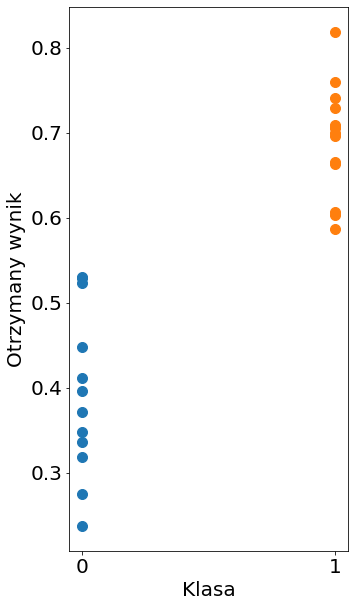

In [84]:
    f = plt.figure()
    f.set_figwidth(5)
    f.set_figheight(10)
    
    plt.rcParams.update({'font.size': 15})
    plt.xlabel('Klasa', fontsize=20)
    plt.ylabel('Otrzymany wynik', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.scatter(['0']*len(Y_zero_class_scores), Y_zero_class_scores, s=100)
    plt.scatter(['1']*len(Y_first_class_scores), Y_first_class_scores, s=100)
    plt.show()  

In [85]:
    print(losses)

10
